In [2]:
import pandas as pd
import numpy as np

In [3]:
# Standardize data format

arrival_departure = pd.read_csv('japan_arrival_departure.csv')[['Year', 'Japanese Overseas Travelers', 'Visitor Arrivals to Japan']]
arrival_departure['Japanese Overseas Travelers'] = arrival_departure['Japanese Overseas Travelers'].apply(lambda x: x.replace(',','')).astype(int)
arrival_departure['Visitor Arrivals to Japan'] = arrival_departure['Visitor Arrivals to Japan'].apply(lambda x: x.replace(',','')).astype(int)
arrival_departure['Year'] = pd.to_datetime(arrival_departure['Year'], format='%Y') - pd.Timedelta(days=1)
arrival_departure = arrival_departure[(arrival_departure['Year'].dt.year >= 2018) & (arrival_departure['Year'].dt.year < 2024)]
#arrival_departure['Year'] = arrival_departure['Year'].dt.to_period('M')
arrival_departure = arrival_departure.set_index('Year').resample('D').bfill().iloc[1:,:]

gdp = pd.read_csv('JPN_GDP.csv')
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp = gdp[gdp['DATE'].dt.year >= 2019]
#gdp['DATE'] = gdp['DATE'].dt.to_period('M')
gdp = gdp.set_index('DATE').resample('D').bfill()

avg_stay = pd.read_csv('japan_visitor_avg_stay.csv')
avg_stay['Year'] = pd.to_datetime(avg_stay['Year'].astype(int)+1, format='%Y') - pd.Timedelta(days=1)
avg_stay = avg_stay[(avg_stay['Year'].dt.year >= 2018) & (avg_stay['Country/Area'] == 'Total')]
avg_stay.drop(columns=['Country/Area'], inplace=True)
avg_stay.loc[len(avg_stay)] = pd.Series({'Year': pd.to_datetime('2023-12-31'), 'Average length of stay': avg_stay['Average length of stay'].median()})
avg_stay.reset_index(drop=True, inplace=True)
#avg_stay['Year'] = avg_stay['Year'].dt.to_period('M')
avg_stay = avg_stay.set_index('Year').resample('D').bfill().iloc[1:,:]

expenditure = pd.read_csv('expenditure.csv')
expenditure['Year'] = expenditure['Year'].astype(int)+1
expenditure['Year'] = pd.to_datetime(expenditure['Year'], format='%Y') - pd.Timedelta(days=1)
#expenditure['Year'] = expenditure['Year'].dt.to_period('M')
expenditure = expenditure.set_index('Year').resample('D').bfill().iloc[1:,:]

cast = {'Jan': '01',
        'Feb': '02',
        'Mar': '03',
        'Apr': '04',
        'May': '05',
        'Jun': '06',
        'Jul': '07',
        'Aug': '08',
        'Sep': '09',
        'Oct': '10',
        'Nov': '11',
        'Dec': '12'}

def parsing(date):
    date = date.split('(')[0]
    month_day, year = date.split(',')
    month, day = month_day.split()
    return f'{year.strip()}-{cast[month]}-{day}'

cpi = pd.read_csv('cpi.csv')[['Date','Actual']]
cpi['Date'] = pd.to_datetime(cpi['Date'].apply(parsing))
cpi = cpi[(cpi['Date'].dt.year >= 2019) & (cpi['Date'].dt.year < 2024)]
# Manually shifted 2019/01/17 to 2019/01/01
# Manually shifted 2023/12/21 to 2023/12/31
cpi = cpi.set_index('Date').resample('D').bfill()
cpi['Actual'] = cpi['Actual'].apply(lambda x: float(x.replace('%',''))/100)

exchange_rate = pd.read_csv('exchange_rate.csv')[['Date','Adj Close']]
exchange_rate['Date'] = pd.to_datetime(exchange_rate['Date'])
#exchange_rate = exchange_rate.groupby(pd.Grouper(key='Date', freq='M')).tail(1)
#exchange_rate['Date'] = exchange_rate['Date'].dt.to_period('M')
exchange_rate = exchange_rate.set_index('Date').resample('D').bfill().iloc[:-2,:]
exchange_rate = exchange_rate.fillna(method='ffill')


/var/folders/ls/6b52gp6s5jx1t8rz93h_291m0000gn/T/ipykernel_78399/1858919826.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exchange_rate = exchange_rate.fillna(method='ffill')


In [4]:
data = pd.concat([arrival_departure, gdp, avg_stay, expenditure, cpi, exchange_rate], axis=1).iloc[:-1,:]
data = data.rename(columns={'Japanese Overseas Travelers': 'Departure', 'Visitor Arrivals to Japan': 'Arrival', 'JPNNGDP': 'GDP', 'Average length of stay': 'Stay Length', 'Adj Close': 'USD/JPY'})
data.tail()

,Departure,Arrival,GDP,Stay Length,Expenditure,Actual,USD/JPY
2023-12-27,3037254.0,5476702.0,598963.1,7.24969,5.31,0.028,142.460999
2023-12-28,3037254.0,5476702.0,598963.1,7.24969,5.31,0.028,141.399002
2023-12-29,3037254.0,5476702.0,598963.1,7.24969,5.31,0.028,141.429993
2023-12-30,3037254.0,5476702.0,598963.1,7.24969,5.31,0.028,140.951996
2023-12-31,3037254.0,5476702.0,598963.1,7.24969,5.31,0.028,140.951996


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols = ['Departure', 'Arrival', 'GDP', 'Stay Length', 'Expenditure', 'Actual']
data[cols] = scaler.fit_transform(data.drop(columns=['USD/JPY']))

In [6]:
data.head()

,Departure,Arrival,GDP,Stay Length,Expenditure,Actual,USD/JPY
2019-01-01,-0.211857,-0.410814,-0.198385,-0.661428,1.10062,-0.607077,109.629997
2019-01-02,-0.211857,-0.410814,-0.065684,-0.661428,1.10062,-0.673416,109.667999
2019-01-03,-0.211857,-0.410814,-0.065684,-0.661428,1.10062,-0.673416,107.441002
2019-01-04,-0.211857,-0.410814,-0.065684,-0.661428,1.10062,-0.673416,107.807999
2019-01-05,-0.211857,-0.410814,-0.065684,-0.661428,1.10062,-0.673416,108.522003


**Analysis**

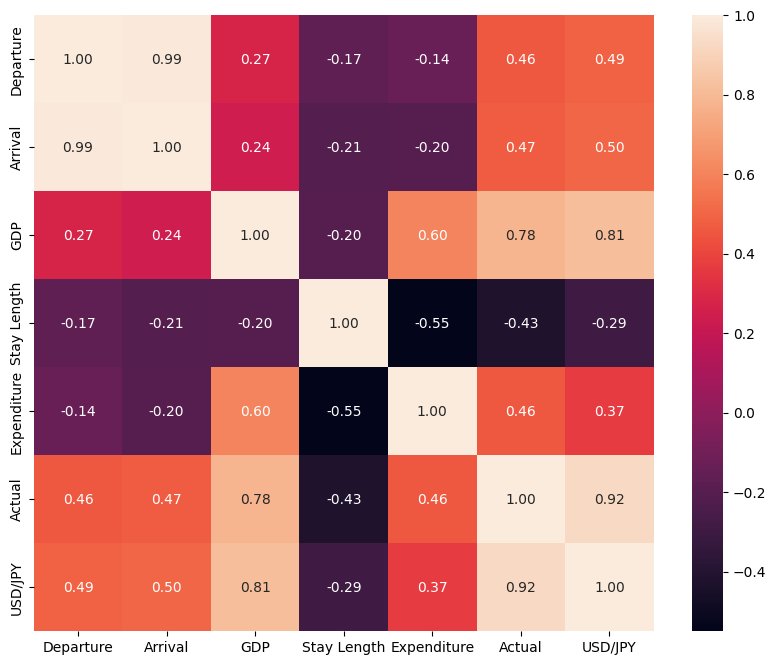

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix, for reference only. It ignores temporal effects.

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f")
plt.show()

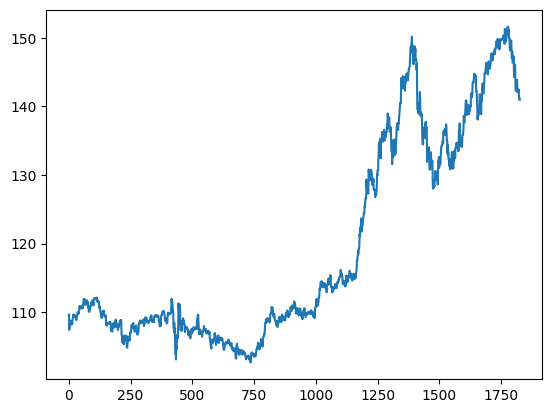

In [8]:
import matplotlib.pyplot as plt

plt.plot(data['USD/JPY'].values)

In [9]:
from statsmodels.tsa.stattools import adfuller

def adfuller_result(adf):
    adf_test = adfuller(adf)
    print('ADF value: %f' % adf_test[0])
    print('P-value: %f' % adf_test[1])
    print('Time lag: %f' % adf_test[2])
    print('Number of observations: %f' % adf_test[3])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

adfuller_result(data['USD/JPY'].values)

ADF value: -0.329741
P-value: 0.921185
Time lag: 0.000000
Number of observations: 1825.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [10]:
# P-value > 0.05, ADF value > critical values, cannot reject null hypothesis => time series is non-stationary

# Start with OLS model
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def getvif(X):
    X = sm.add_constant(X)
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["Predictors"] = X.columns
    return(vif.drop(index = 0).round(2)) 

X = data[['Departure', 'Arrival', 'GDP', 'Stay Length', 'Expenditure', 'Actual']]
X = sm.add_constant(X)
y = data['USD/JPY']

getvif(X)

,VIF,Predictors
1,567.45,Departure
2,708.28,Arrival
3,6.69,GDP
4,16.24,Stay Length
5,37.11,Expenditure
6,6.29,Actual


In [11]:
# Given that VIF > 5, we drop departure
data_ols = data.drop(columns=['Departure'])
# Add time for time series
data_ols['Time'] = np.arange(len(data_ols))

X = data_ols[['Time', 'Arrival', 'GDP', 'Stay Length', 'Expenditure', 'Actual']]
X = sm.add_constant(X)
y = data_ols['USD/JPY']

getvif(X)

,VIF,Predictors
1,7.84,Time
2,2.18,Arrival
3,8.35,GDP
4,2.55,Stay Length
5,6.46,Expenditure
6,6.48,Actual


In [12]:
data.describe()

,Departure,Arrival,GDP,Stay Length,Expenditure,Actual,USD/JPY
count,1826.000000,1826.000000,1.826000e+03,1.826000e+03,1.826000e+03,1.826000e+03,1826.000000
mean,0.000000,0.000000,-1.058421e-15,-2.801702e-16,-1.867801e-16,-1.245201e-16,119.489394
std,1.000274,1.000274,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,14.981608
min,-1.082301,-0.849095,-2.316030e+00,-6.614275e-01,-1.019351e+00,-1.602160e+00,102.678001
25%,-0.343454,-0.442945,-5.661797e-01,-4.559380e-01,-7.390987e-01,-6.734158e-01,108.211998
50%,-0.256643,-0.410814,-3.308946e-01,-4.559380e-01,-6.667756e-01,-4.743992e-01,110.764000
75%,-0.211857,-0.256692,2.646856e-01,-4.189182e-01,1.100620e+00,1.184072e+00,134.066505
max,1.897220,1.961872,1.739923e+00,1.993369e+00,1.326630e+00,2.046478e+00,151.645996


In [13]:
# We predict the last 3 months
train_X = X.iloc[:-30,:]
train_y = y.iloc[:-30]
test_X = X.iloc[-30:,:]
test_y = y.iloc[-30:]

ols_model = OLS(train_y, train_X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                USD/JPY   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     3231.
Date:                Sun, 26 May 2024   Prob (F-statistic):               0.00
Time:                        16:21:10   Log-Likelihood:                -5164.6
No. Observations:                1796   AIC:                         1.034e+04
Df Residuals:                    1789   BIC:                         1.038e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         109.0554      0.511    213.546      

In [14]:
from sklearn.metrics import mean_squared_error

# Compare RMSE of training and test set
ols_train_rmse = mean_squared_error(train_y, ols_model.predict(train_X), squared=False)
ols_test_rmse = mean_squared_error(test_y, ols_model.predict(test_X), squared=False)
print('OLS training RMSE: %.4f' % ols_train_rmse)
print('OLS test RMSE: %.4f' % ols_test_rmse)

OLS training RMSE: 4.2917
OLS test RMSE: 4.2532


/opt/miniconda3/envs/general/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/miniconda3/envs/general/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

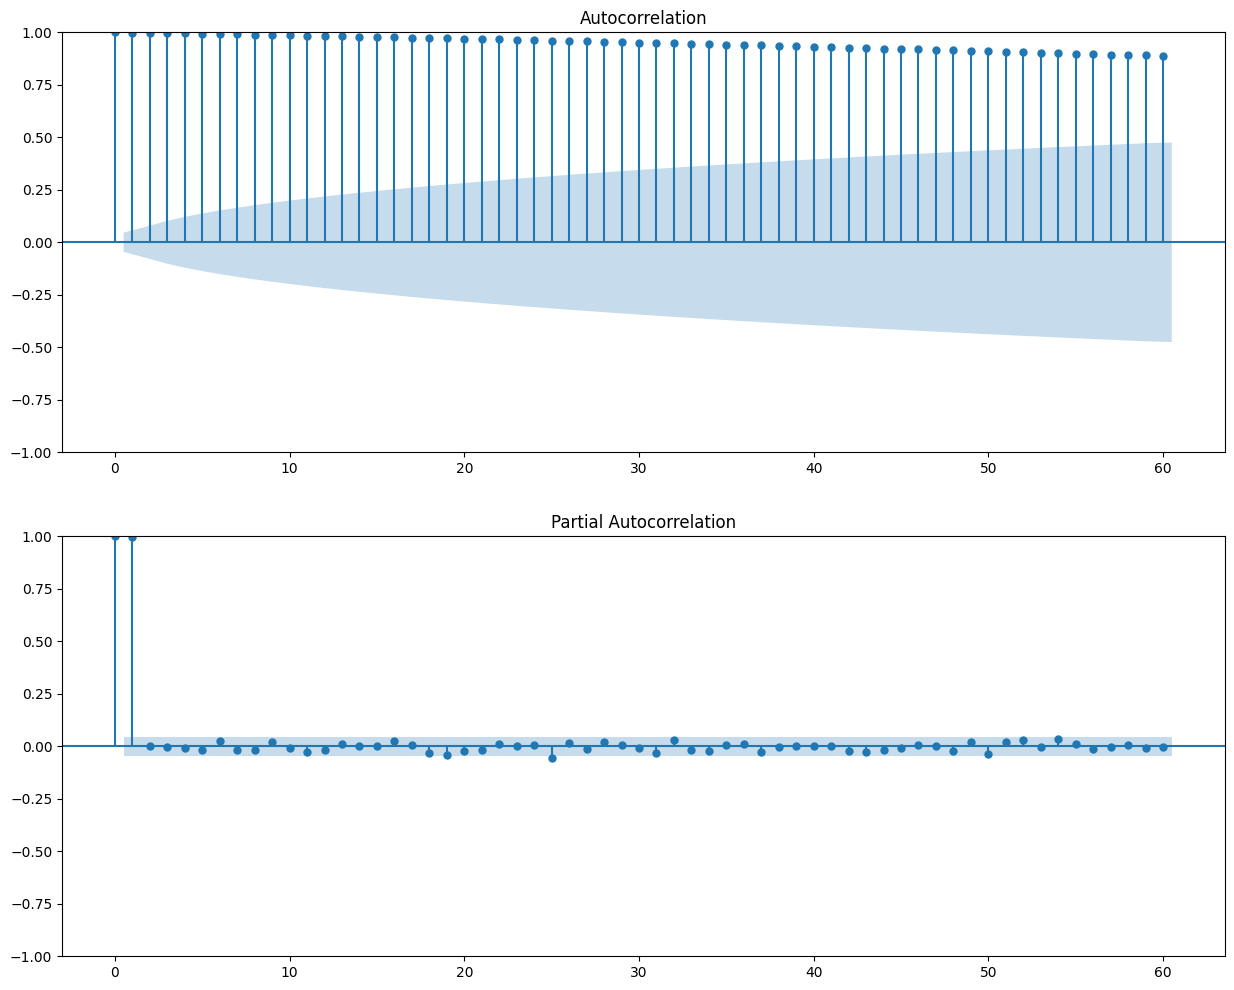

In [48]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.clf()
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
plot_acf = plot_acf(data['USD/JPY'], lags=60, ax=ax[0])
plot_pacf = plot_pacf(data['USD/JPY'], lags=60, ax=ax[1])

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

y = data['USD/JPY']
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
for train_index, test_index in tscv.split(y):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = ARIMA(y_train, order=(1, 1, 1))
    model_fit = model.fit()
    y_pred = model_fit.forecast(steps=len(y_test))

    rmse = sqrt(mean_squared_error(y_test.values, y_pred))
    rmse_scores.append(rmse)

print(f'RMSE scores: {rmse_scores}')

/opt/miniconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE scores: [1.5415906854986936, 2.515178302540467, 6.205480126660048, 8.740919551504787, 8.50706687587515]


In [19]:
import pmdarima.arima as pm

model = pm.auto_arima(y_train, 
                      m=52,               # frequency of series                      
                      seasonal=True,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=50, max_q=50, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=3075.391, Time=22.25 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3072.268, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3075.479, Time=9.25 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3075.458, Time=12.92 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3072.801, Time=0.07 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=3073.484, Time=9.10 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=3073.464, Time=5.98 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=3074.268, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=3074.268, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=3074.566, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[52] intercept
Total fit time: 60.216 seconds


In [21]:
model = pm.auto_arima(y_train, 
                      m=12,               # frequency of series                      
                      seasonal=True,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=50, max_q=50, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3067.561, Time=1.70 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3072.268, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3075.782, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3075.788, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3072.801, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3073.789, Time=0.75 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3073.783, Time=0.35 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=3068.562, Time=5.53 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3068.698, Time=5.32 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=3075.726, Time=1.82 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=3075.683, Time=0.96 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=17.17 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3069.561, Time=2.34 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3069.561, Time=2.71 sec
 ARIMA(1,1,1)(1,0,1)[12

In [22]:
y_train = data['USD/JPY'].iloc[:-30]
y_test = data['USD/JPY'].iloc[-30:]

model = ARIMA(y_train, order=(0, 1, 0))
model_fit = model.fit()
y_pred = model_fit.forecast(steps=len(y_test))

arima_train_rmse = sqrt(mean_squared_error(y_train.values, model_fit.fittedvalues))
arima_test_rmse = sqrt(mean_squared_error(y_test.values, y_pred))

print(f'ARIMA training RMSE: {arima_train_rmse}')
print(f'ARIMA test RMSE: {arima_test_rmse}')

ARIMA training RMSE: 2.6487223094463377
ARIMA test RMSE: 4.706877804795711


In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

X = data[['Arrival', 'GDP', 'Stay Length', 'Expenditure', 'Actual']]
y = data['USD/JPY']

X_train = X.iloc[:-30,:]
y_train = y.iloc[:-30]
X_test = X.iloc[-30:,:]
y_test = y.iloc[-30:]

model = SARIMAX(y_train, exog=X_train, order=(0, 1, 0), seasonal_order=(0, 0, 0, 52))
model_fit = model.fit()
y_pred = model_fit.forecast(steps=len(y_test), exog=X_test)

sarimax_train_rmse = sqrt(mean_squared_error(y_train.values, model_fit.fittedvalues))
sarimax_test_rmse = sqrt(mean_squared_error(y_test.values, y_pred))

print(f'SARIMAX training RMSE: {sarimax_train_rmse}')
print(f'SARIMAX test RMSE: {sarimax_test_rmse}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09930D+00    |proj g|=  4.14411D-02


 This problem is unconstrained.



At iterate    5    f=  8.54450D-01    |proj g|=  7.83527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     22      1     0     0   1.012D-07   8.544D-01
  F =  0.85444982058182406     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMAX training RMSE: 2.651601659694071
SARIMAX test RMSE: 4.706877804795711


In [24]:
X = data[['Arrival', 'GDP', 'Stay Length', 'Expenditure', 'Actual']]
y = data['USD/JPY']

X_train = X.iloc[:-30,:]
y_train = y.iloc[:-30]
X_test = X.iloc[-30:,:]
y_test = y.iloc[-30:]

model = SARIMAX(y_train, exog=X_train, order=(0, 1, 0), seasonal_order=(1, 0, 1, 12))
model_fit = model.fit()
y_pred = model_fit.forecast(steps=len(y_test), exog=X_test)

sarimax_train_rmse = sqrt(mean_squared_error(y_train.values, model_fit.fittedvalues))
sarimax_test_rmse = sqrt(mean_squared_error(y_test.values, y_pred))

print(f'SARIMAX training RMSE: {sarimax_train_rmse}')
print(f'SARIMAX test RMSE: {sarimax_test_rmse}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54317D-01    |proj g|=  1.22522D-02


 This problem is unconstrained.



At iterate    5    f=  8.54303D-01    |proj g|=  6.61966D-04

At iterate   10    f=  8.54298D-01    |proj g|=  7.61732D-04

At iterate   15    f=  8.54218D-01    |proj g|=  6.60255D-03

At iterate   20    f=  8.53405D-01    |proj g|=  2.24465D-02

At iterate   25    f=  8.51989D-01    |proj g|=  1.61652D-02

At iterate   30    f=  8.51822D-01    |proj g|=  4.30366D-03

At iterate   35    f=  8.51806D-01    |proj g|=  1.62921D-04

At iterate   40    f=  8.51804D-01    |proj g|=  5.16045D-04

At iterate   45    f=  8.51802D-01    |proj g|=  5.27219D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     60   

**Predict change**

In [34]:
data['Diff'] = data['USD/JPY'].diff()
data_diff = data.dropna().drop(columns=['USD/JPY'])
data_diff.head()

,Departure,Arrival,GDP,Stay Length,Expenditure,Actual,Diff
2019-01-02,-0.211857,-0.410814,-0.065684,-0.661428,1.10062,-0.673416,0.038002
2019-01-03,-0.211857,-0.410814,-0.065684,-0.661428,1.10062,-0.673416,-2.226997
2019-01-04,-0.211857,-0.410814,-0.065684,-0.661428,1.10062,-0.673416,0.366997
2019-01-05,-0.211857,-0.410814,-0.065684,-0.661428,1.10062,-0.673416,0.714004
2019-01-06,-0.211857,-0.410814,-0.065684,-0.661428,1.10062,-0.673416,0.000000


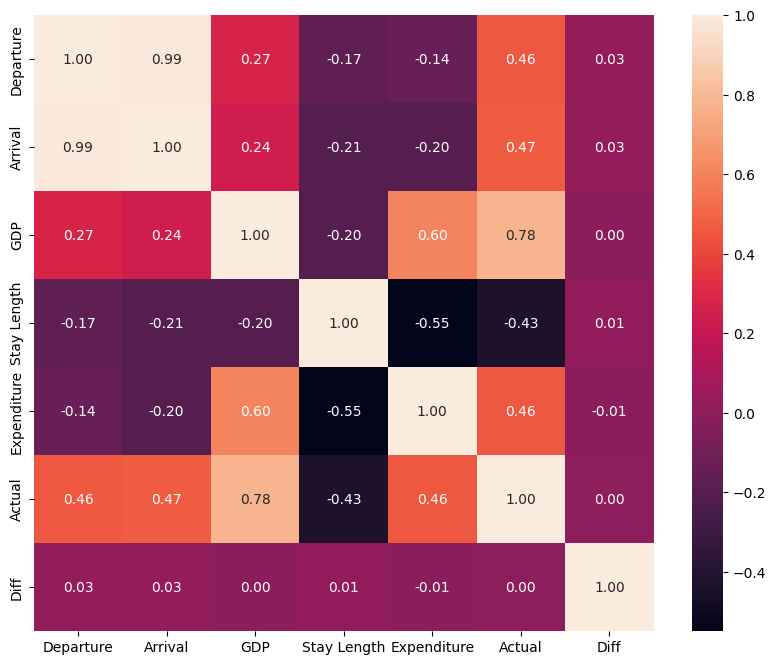

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_diff.corr(), annot=True, fmt=".2f")
plt.show()

In [36]:
adfuller_result(data_diff['Diff'].values)

ADF value: -31.790938
P-value: 0.000000
Time lag: 1.000000
Number of observations: 1823.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [39]:
X = data_diff[['Departure', 'Arrival', 'GDP', 'Stay Length', 'Expenditure', 'Actual']]
X = sm.add_constant(X)
y = data_diff['Diff']

getvif(X)

,VIF,Predictors
1,567.63,Departure
2,708.42,Arrival
3,6.69,GDP
4,16.24,Stay Length
5,37.08,Expenditure
6,6.29,Actual


In [41]:
data_ols = data_diff.drop(columns=['Departure'])
# Add time for time series
data_ols['Time'] = np.arange(len(data_ols))

X = data_ols[['Time', 'Arrival', 'GDP', 'Stay Length', 'Expenditure', 'Actual']]
X = sm.add_constant(X)
y = data_ols['Diff']

getvif(X)

,VIF,Predictors
1,7.84,Time
2,2.18,Arrival
3,8.35,GDP
4,2.55,Stay Length
5,6.46,Expenditure
6,6.48,Actual


In [43]:
train_X = X.iloc[:-30,:]
train_y = y.iloc[:-30]
test_X = X.iloc[-30:,:]
test_y = y.iloc[-30:]

# Result suggests that the selected variables cannot be used to predict the change in exchange rate directly
# So RMSE is not calculated
ols_model = OLS(train_y, train_X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Diff   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.557
Date:                Sun, 26 May 2024   Prob (F-statistic):              0.156
Time:                        16:35:15   Log-Likelihood:                -1529.5
No. Observations:                1795   AIC:                             3073.
Df Residuals:                    1788   BIC:                             3111.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1434      0.067     -2.125      

<Figure size 640x480 with 0 Axes>

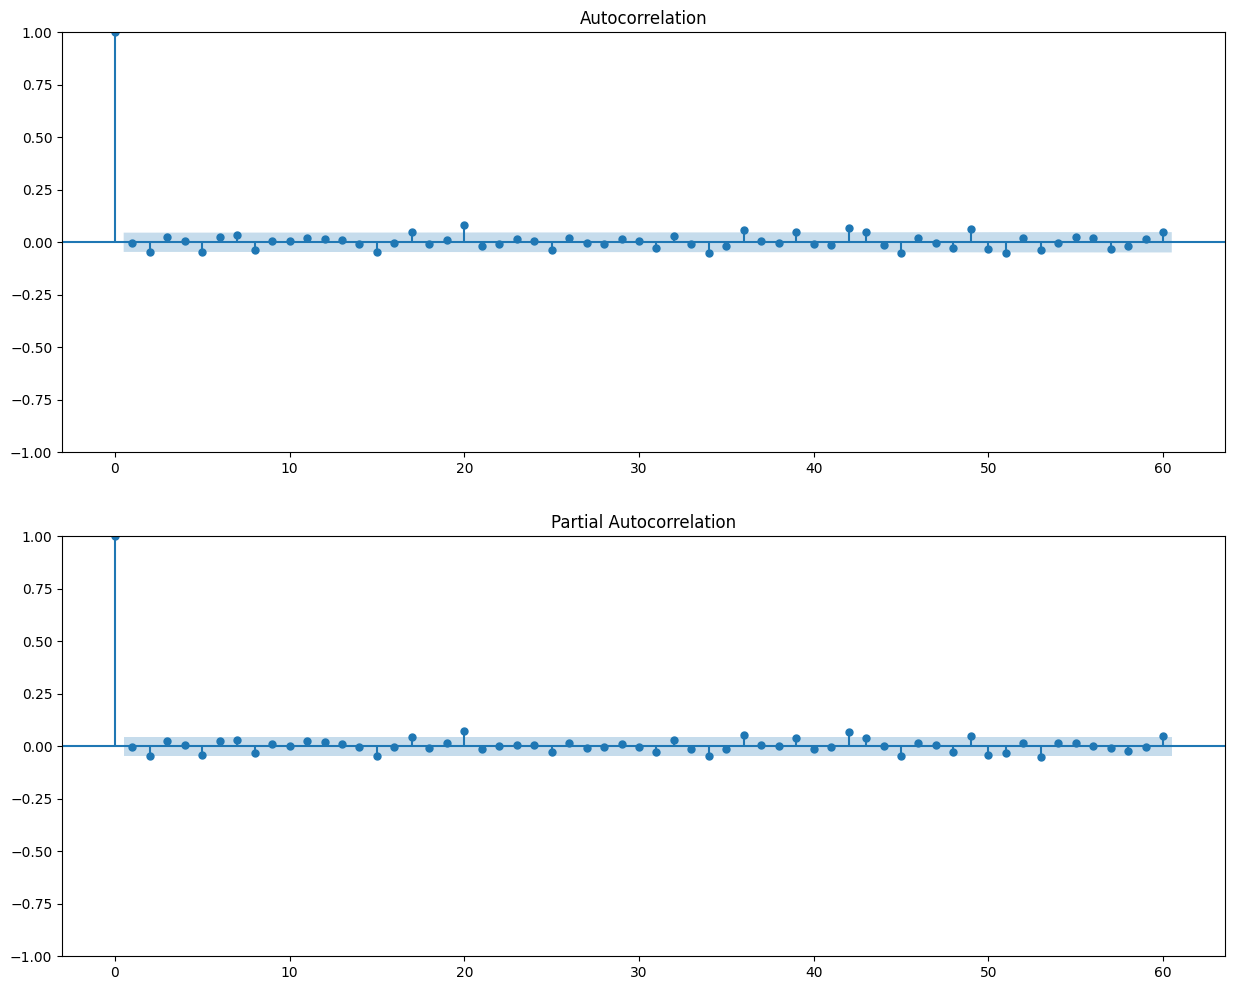

In [50]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.clf()
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
plot_acf = plot_acf(data_diff['Diff'], lags=60, ax=ax[0])
plot_pacf = plot_pacf(data_diff['Diff'], lags=60, ax=ax[1])

In [ ]:
# ACF and PACF shows significance at lag = 0, 20, 36, 42
# We try (3,0,1)

In [51]:
y = data_diff['Diff']
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
for train_index, test_index in tscv.split(y):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = ARIMA(y_train, order=(3, 0, 1))
    model_fit = model.fit()
    y_pred = model_fit.forecast(steps=len(y_test))

    rmse = sqrt(mean_squared_error(y_test.values, y_pred))
    rmse_scores.append(rmse)

print(f'RMSE scores: {rmse_scores}')

/opt/miniconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/miniconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/miniconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible s

RMSE scores: [0.4949922939741107, 0.2899677434920297, 0.43328712742416325, 0.9261062863613878, 0.7040404767986772]


In [53]:
model = pm.auto_arima(y_train, 
                      m=52,               # frequency of series                      
                      seasonal=True,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=50, max_q=50, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=2492.485, Time=11.86 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2489.468, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2492.569, Time=5.05 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2492.544, Time=6.98 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2489.013, Time=0.05 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=2490.577, Time=4.14 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=2490.553, Time=4.25 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2491.439, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=2491.436, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=2492.521, Time=0.30 sec

Best model:  ARIMA(0,0,0)(0,0,0)[52]          
Total fit time: 32.990 seconds


In [54]:
model = pm.auto_arima(y_train, 
                      m=12,               # frequency of series                      
                      seasonal=True,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=50, max_q=50, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=2488.598, Time=1.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2489.468, Time=0.15 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2492.878, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2492.885, Time=1.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2489.013, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=2490.926, Time=1.14 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=2490.915, Time=0.59 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=2490.338, Time=7.38 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=9.23 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=2492.778, Time=1.47 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2492.750, Time=0.94 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=8.24 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2490.570, Time=1.54 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2490.567, Time=1.75 sec
 ARIMA(1,0,1)(1,0,1)[12] inte

In [55]:
y_train = data_diff['Diff'].iloc[:-30]
y_test = data_diff['Diff'].iloc[-30:]

model = ARIMA(y_train, order=(0, 0, 0))
model_fit = model.fit()
y_pred = model_fit.forecast(steps=len(y_test))

arima_train_rmse = sqrt(mean_squared_error(y_train.values, model_fit.fittedvalues))
arima_test_rmse = sqrt(mean_squared_error(y_test.values, y_pred))

print(f'ARIMA training RMSE: {arima_train_rmse}')
print(f'ARIMA test RMSE: {arima_test_rmse}')

ARIMA training RMSE: 0.5687764579090353
ARIMA test RMSE: 0.9379531957821646


In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

X = data_diff[['Arrival', 'GDP', 'Stay Length', 'Expenditure', 'Actual']]
y = data_diff['Diff']

X_train = X.iloc[:-30,:]
y_train = y.iloc[:-30]
X_test = X.iloc[-30:,:]
y_test = y.iloc[-30:]

model = SARIMAX(y_train, exog=X_train, order=(0, 0, 0), seasonal_order=(0, 0, 0, 52))
model_fit = model.fit()
y_pred = model_fit.forecast(steps=len(y_test), exog=X_test)

sarimax_train_rmse = sqrt(mean_squared_error(y_train.values, model_fit.fittedvalues))
sarimax_test_rmse = sqrt(mean_squared_error(y_test.values, y_pred))

print(f'SARIMAX training RMSE: {sarimax_train_rmse}')
print(f'SARIMAX test RMSE: {sarimax_test_rmse}')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10116D+00    |proj g|=  4.14817D-02

At iterate    5    f=  8.54505D-01    |proj g|=  1.43889D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     22      1     0     0   6.372D-06   8.545D-01
  F =  0.85450490908711152     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMAX training RMSE: 0.5686821433704924
SARIMAX test RMSE: 0.9321671957017459


In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

X = data_diff[['Arrival', 'GDP', 'Stay Length', 'Expenditure', 'Actual']]
y = data_diff['Diff']

X_train = X.iloc[:-30,:]
y_train = y.iloc[:-30]
X_test = X.iloc[-30:,:]
y_test = y.iloc[-30:]

model = SARIMAX(y_train, exog=X_train, order=(0, 0, 0), seasonal_order=(1, 0, 1, 12))
model_fit = model.fit()
y_pred = model_fit.forecast(steps=len(y_test), exog=X_test)

sarimax_train_rmse = sqrt(mean_squared_error(y_train.values, model_fit.fittedvalues))
sarimax_test_rmse = sqrt(mean_squared_error(y_test.values, y_pred))

print(f'SARIMAX training RMSE: {sarimax_train_rmse}')
print(f'SARIMAX test RMSE: {sarimax_test_rmse}')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54382D-01    |proj g|=  1.22237D-02


 This problem is unconstrained.



At iterate    5    f=  8.54368D-01    |proj g|=  1.35890D-04

At iterate   10    f=  8.54363D-01    |proj g|=  1.94569D-03

At iterate   15    f=  8.53741D-01    |proj g|=  3.43154D-02

At iterate   20    f=  8.52193D-01    |proj g|=  3.58003D-03

At iterate   25    f=  8.52099D-01    |proj g|=  5.06134D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     38      1     0     0   6.763D-06   8.521D-01
  F =  0.85209841313534673     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMAX training RMSE: 0.5672991709787975
SARIMAX test RMSE: 0.9358269273485442


In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

X = data_diff[['Arrival', 'GDP', 'Stay Length', 'Expenditure', 'Actual']]
y = data_diff['Diff']

X_train = X.iloc[:-30,:]
y_train = y.iloc[:-30]
X_test = X.iloc[-30:,:]
y_test = y.iloc[-30:]

model = SARIMAX(y_train, exog=X_train, order=(0, 0, 0), seasonal_order=(1, 0, 1, 365))
model_fit = model.fit()
y_pred = model_fit.forecast(steps=len(y_test), exog=X_test)

sarimax_train_rmse = sqrt(mean_squared_error(y_train.values, model_fit.fittedvalues))
sarimax_test_rmse = sqrt(mean_squared_error(y_test.values, y_pred))

print(f'SARIMAX training RMSE: {sarimax_train_rmse}')
print(f'SARIMAX test RMSE: {sarimax_test_rmse}')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34151D-01    |proj g|=  5.99334D-01

At iterate    5    f=  8.53527D-01    |proj g|=  1.88511D-03

At iterate   10    f=  8.53524D-01    |proj g|=  2.67788D-04

At iterate   15    f=  8.53524D-01    |proj g|=  9.30862D-05

At iterate   20    f=  8.53523D-01    |proj g|=  8.22495D-04

At iterate   25    f=  8.53522D-01    |proj g|=  8.26008D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     32      1     0     0   